# <span style="color: blue;">ให้กรอกรหัสนิสิต และชื่อ-นามสกุลของสมาชิกในทีม</span>
# <span style="color: blue;">(ห้ามมีสมาชิกเกิน 2 คน)</span>
## รหัสนิสิต ชื่อ-นามสกุล

## Image Classification: Comparing No Augmentation, Data Augmentation, and Pretrained Models

This exercise investigates image classification on the CIFAR-100 dataset by comparing three different training strategies: a baseline model trained without any augmentation, a model trained with data augmentation techniques to improve generalization, and a model leveraging transfer learning with pretrained weights. The goal is to evaluate how each approach affects classification performance, focusing on accuracy, loss behavior, and robustness.

In [1]:
import os

# must come *before* any Tensorflow import
os.environ['TF_DETERMINISTIC_OPS'] = '1'
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [2]:
from __future__ import print_function
import keras
from keras.datasets import cifar100
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import numpy as np
import os, random, tensorflow as tf
import requests, pickle

def set_seed(seed_value=12345):
    random.seed(seed_value)
    np.random.seed(seed_value)
    tf.random.set_seed(seed_value)
    os.environ['PYTHONHASHSEED'] = str(seed_value)

## Testing ImageDataGenerator

In [4]:
%pip install gdown

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


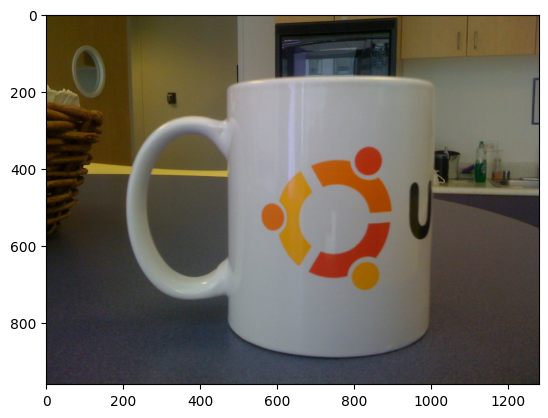

In [5]:
import gdown, requests
from PIL import Image
import numpy as np

gdown.download("https://drive.google.com/uc?export=download&id=1xUwP3DVt690D2NpgDdoNaNE37uoa0a3V", 
               "coffee_mug.jpg", quiet=True)
image = Image.open("coffee_mug.jpg")
image = np.expand_dims(image, axis=0).astype('float32')/255
plt.imshow(image[0])

In [6]:
datagen = ImageDataGenerator(
    rotation_range=5,  # randomly rotate images in the range (degrees, 0 to 180)
    width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=True,  # randomly flip images
    vertical_flip=False)  # randomly flip images

image_generator = datagen.flow(image)

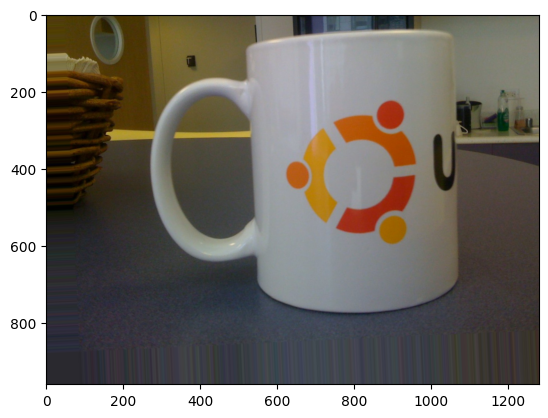

In [7]:
plt.imshow(next(image_generator)[0])

## Loading Dataset

In [8]:
url = "https://drive.google.com/uc?id=1KiNBzO6Rglrs96Ar92sVjYckAvm2A0Fi"
(_X, _y) = pickle.loads(requests.get(url).content)

class_names = ['bottle', 'bowl', 'can', 'cup', 'plate']

## <span style="color:orange"> เกณฑ์การให้คะแนน (คะแนนเต็ม 100 คะแนน)</span>
* ### เพื่อป้องกันผลกระทบจาก randomness ให้นิสิตใช้ค่า seed เป็น 12345 ในทุกกรณีที่เกี่ยวข้องกับการสุ่ม และให้เรียกใช้ฟังก์ชัน set_seed(12345) ทุกครั้งก่อนที่จะสร้างโมเดล
* ### <span style="color:darkcyan"> หากสามารถทำตามข้อกำหนดได้ครบและสมบูรณ์ทุกข้อ พร้อมอธิบายและเปรียบเทียบประสิทธิภาพของโมเดลทั้งหมดได้อย่างชัดเจน ได้รับคะแนนเต็ม 100 คะแนน</span>
* ### <span style="color:darkcyan"> หากมีข้อบกพร่องน้อยหรืออธิบายได้ดีพอประมาณ จะได้รับ 70 คะแนน</span>
* ### <span style="color:darkcyan"> หากมีข้อบกพร่องหรือโค้ดทำงานไม่ถูกต้อง จะได้รับ 40 คะแนน</span>
* ### <span style="color:darkcyan"> หากมีข้อบกพร่องอย่างมาก โค้ดรันไม่ได้ หรือไม่ได้เขียนโค้ดส่งมา จะได้รับศูนย์คะแนน</span>
* ### <span style="color:darkcyan"> หากโจทย์ไม่ได้กำหนดให้ทำ </span><span style="color:red">ห้ามใช้ Early Stopping, ห้ามใช้ Best Weights, ห้ามใช้ Data Augmentation และห้ามใช้โมเดล Pretrained ในการเทรนโมเดล</span>

## <span style="color:green"> 1. จากชุดข้อมูลที่เตรียมไว้ให้ซึ่งอยู่ในตัวแปร _X และ _y ให้แบ่งข้อมูลออกเป็นชุดข้อมูล train, val, และ test ด้วยอัตราส่วน 80:5:15 และให้ทุกชุดข้อมูลมีจำนวนข้อมูลของแต่ละคลาสเท่ากัน หลังจากที่แบ่งชุดข้อมูลเสร็จ ให้แสดงจำนวนข้อมูลของแต่ละคลาสในทุกชุดข้อมูล</span>

In [9]:
from sklearn.model_selection import train_test_split

In [10]:
X_train, X_test, y_train, y_test = train_test_split(_X, _y, test_size=0.2, stratify=_y, random_state=12345)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.25, stratify=y_test, random_state=12345)

In [11]:
print('# of samples for each set')
print(f'Train set: {X_train.shape[0]} samples ({X_train.shape[0]/_X.shape[0]*100:.1f}%)')
print(f'  Val set: {X_val.shape[0]} samples  ({X_val.shape[0]/_X.shape[0]*100:.1f}%)')
print(f' Test set: {X_test.shape[0]} samples  ({X_test.shape[0]/_X.shape[0]*100:.1f}%)')

# of samples for each set
Train set: 2400 samples (80.0%)
  Val set: 450 samples  (15.0%)
 Test set: 150 samples  (5.0%)


In [12]:
print('Class distribution in the training set')
for i, class_name in enumerate(class_names):
    print(f'  {class_name:6s}: {(y_train==i).sum()}')

Class distribution in the training set
  bottle: 480
  bowl  : 480
  can   : 480
  cup   : 480
  plate : 480


In [13]:
print('Class distribution in the validation set')
for i, class_name in enumerate(class_names):
    print(f'  {class_name:6s}: {(y_val==i).sum()}')

Class distribution in the validation set
  bottle: 90
  bowl  : 90
  can   : 90
  cup   : 90
  plate : 90


In [14]:
print('Class distribution in the test set')
for i, class_name in enumerate(class_names):
    print(f'  {class_name:6s}: {(y_test==i).sum()}')

Class distribution in the test set
  bottle: 30
  bowl  : 30
  can   : 30
  cup   : 30
  plate : 30


## <span style="color:green"> 2. ในแต่ละชุดข้อมูล ให้แสดงภาพพร้อมชื่อคลาสออกมาเป็นจำนวน 12 ภาพ</span>

Sample images from the training set


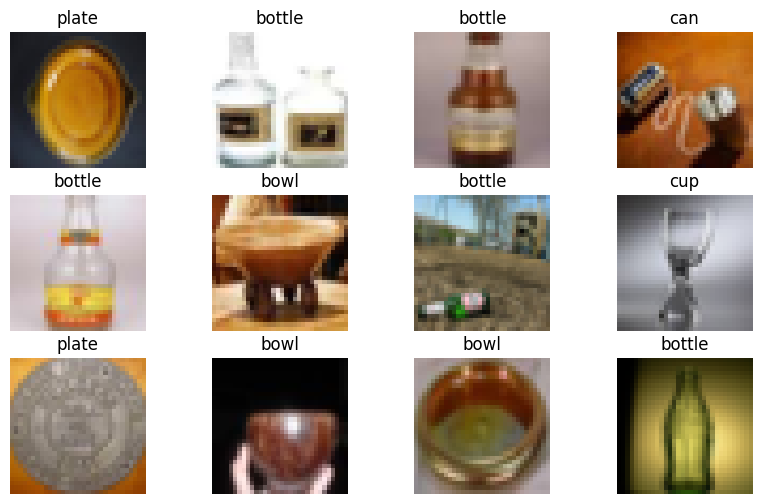

In [15]:
print('Sample images from the training set')
fig, axes = plt.subplots(3, 4, figsize=(10, 6))
for i, ax in enumerate(axes.flat):
    ax.imshow(X_train[i])
    ax.set_title(class_names[y_train[i][0]])
    ax.axis('off')

Sample images from the validation set


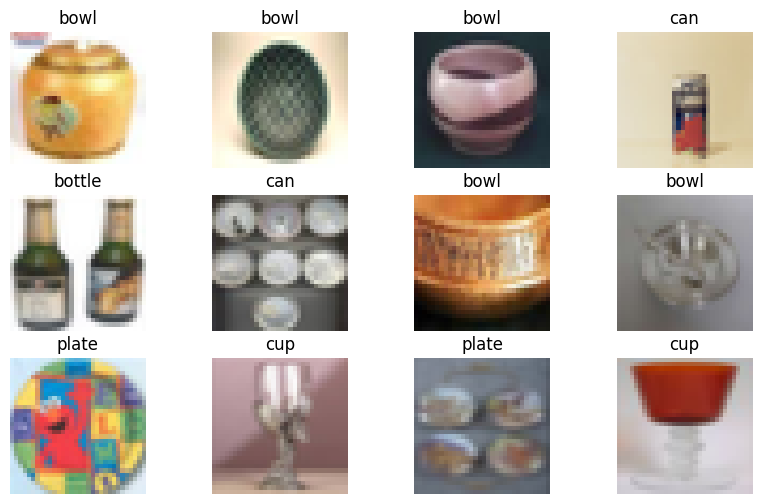

In [16]:
print('Sample images from the validation set')
fig, axes = plt.subplots(3, 4, figsize=(10, 6))
for i, ax in enumerate(axes.flat):
    ax.imshow(X_val[i])
    ax.set_title(class_names[y_val[i][0]])
    ax.axis('off')

Sample images from the test set


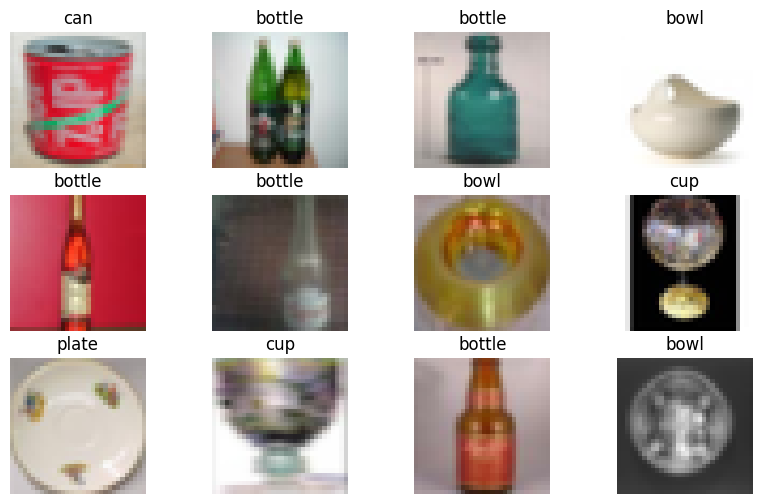

In [17]:
print('Sample images from the test set')
fig, axes = plt.subplots(3, 4, figsize=(10, 6))
for i, ax in enumerate(axes.flat):
    ax.imshow(X_test[i])
    ax.set_title(class_names[y_test[i][0]])
    ax.axis('off')

### Normalize and One-Hot Encode Datasets โดยปรับโค้ดข้างล่างให้ตรงกับตัวแปรที่ใช้

In [18]:
n_classes = len(class_names)

X_train = X_train.astype('float32') / 255
X_val = X_val.astype('float32') / 255
X_test = X_test.astype('float32') / 255

y_train = keras.utils.to_categorical(y_train, n_classes)
y_val = keras.utils.to_categorical(y_val, n_classes)
y_test = keras.utils.to_categorical(y_test, n_classes)

## <span style="color:green"> 3. ให้สร้าง เทรน และประเมินผลโมเดล CNN โดยให้ตั้งชื่อตัวแปรโมเดลว่า model_1 ซึ่งในการเทรนโมเดลนี้ห้ามใช้ Data Augmentation</span>

In [19]:
set_seed(12345)

model_1 = Sequential()

model_1.add(Conv2D(32, (3, 3), input_shape=X_train.shape[1:], activation='relu'))
model_1.add(MaxPooling2D(pool_size=(2, 2)))
model_1.add(Conv2D(64, (3, 3), activation='relu'))
model_1.add(MaxPooling2D(pool_size=(2, 2)))
model_1.add(Flatten())
model_1.add(Dense(128, activation='relu'))
model_1.add(Dropout(0.2))
model_1.add(Dense(64, activation='relu'))
model_1.add(Dropout(0.2))
model_1.add(Dense(n_classes, activation='softmax'))

model_1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 2304)              0         
                                                                 
 dense (Dense)               (None, 128)               2

In [20]:
model_1.fit(X_train, y_train, batch_size=32, epochs=50, validation_data=(X_val, y_val))

Epoch 1/50
75/75 [==============================] - 2s 15ms/step - loss: 1.5269 - accuracy: 0.3237 - val_loss: 1.3487 - val_accuracy: 0.4711
Epoch 2/50
75/75 [==============================] - 1s 13ms/step - loss: 1.2598 - accuracy: 0.4871 - val_loss: 1.1096 - val_accuracy: 0.5578
Epoch 3/50
75/75 [==============================] - 1s 13ms/step - loss: 1.0689 - accuracy: 0.5825 - val_loss: 0.9825 - val_accuracy: 0.6178
Epoch 4/50
75/75 [==============================] - 1s 12ms/step - loss: 0.9278 - accuracy: 0.6446 - val_loss: 0.9342 - val_accuracy: 0.6133
Epoch 5/50
75/75 [==============================] - 1s 13ms/step - loss: 0.8445 - accuracy: 0.6812 - val_loss: 0.8609 - val_accuracy: 0.6667
Epoch 6/50
75/75 [==============================] - 1s 12ms/step - loss: 0.7777 - accuracy: 0.6992 - val_loss: 0.8745 - val_accuracy: 0.6644
Epoch 7/50
75/75 [==============================] - 1s 12ms/step - loss: 0.6921 - accuracy: 0.7350 - val_loss: 0.8502 - val_accuracy: 0.6778
Epoch 8/50
75

## <span style="color:green"> 4. ให้นำโครงสร้างโมเดล model_1 มาสร้างโมเดลที่มีชื่อตัวแปรโมเดลว่า model_2 โดยห้ามปรับเปลี่ยนโครงสร้างโมเดล แต่ให้เทรนโมเดลโดยใช้ Data Augmentation และใช้จำนวน epoch เท่ากับโมเดลก่อนหน้า</span>

In [21]:
set_seed(12345)

model_2 = Sequential()

model_2.add(Conv2D(32, (3, 3), input_shape=X_train.shape[1:], activation='relu'))
model_2.add(MaxPooling2D(pool_size=(2, 2)))
model_2.add(Conv2D(64, (3, 3), activation='relu'))
model_2.add(MaxPooling2D(pool_size=(2, 2)))
model_2.add(Flatten())
model_2.add(Dense(128, activation='relu'))
model_2.add(Dropout(0.2))
model_2.add(Dense(64, activation='relu'))
model_2.add(Dropout(0.2))
model_2.add(Dense(n_classes, activation='softmax'))

model_2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 15, 15, 32)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 2304)              0         
                                                                 
 dense_3 (Dense)             (None, 128)              

In [22]:
model_2.fit(datagen.flow(X_train, y_train, batch_size=32), validation_data=(X_val, y_val), epochs=50)

Epoch 1/50
75/75 [==============================] - 2s 26ms/step - loss: 1.5683 - accuracy: 0.2713 - val_loss: 1.4199 - val_accuracy: 0.3978
Epoch 2/50
75/75 [==============================] - 2s 24ms/step - loss: 1.3940 - accuracy: 0.3942 - val_loss: 1.2074 - val_accuracy: 0.5156
Epoch 3/50
75/75 [==============================] - 2s 25ms/step - loss: 1.2471 - accuracy: 0.4950 - val_loss: 1.0664 - val_accuracy: 0.6156
Epoch 4/50
75/75 [==============================] - 2s 24ms/step - loss: 1.1271 - accuracy: 0.5508 - val_loss: 0.9647 - val_accuracy: 0.6244
Epoch 5/50
75/75 [==============================] - 2s 25ms/step - loss: 1.0514 - accuracy: 0.5938 - val_loss: 0.8842 - val_accuracy: 0.6689
Epoch 6/50
75/75 [==============================] - 2s 25ms/step - loss: 0.9946 - accuracy: 0.6137 - val_loss: 0.8596 - val_accuracy: 0.6978
Epoch 7/50
75/75 [==============================] - 2s 25ms/step - loss: 0.9399 - accuracy: 0.6371 - val_loss: 0.8222 - val_accuracy: 0.7022
Epoch 8/50
75

## <span style="color:green"> 5. ให้เรียกใช้ฟังก์ชันเพื่อดาวน์โหลดโมเดล Pretrained และทำ fine-tuning เพื่อแสดงความเข้าใจในเรื่อง Transfer Learning โดยให้ตั้งชื่อตัวแปรโมเดลนี้ว่า model_3 และเทรนโมเดลเพิ่มด้วยการใช้ Data Augmentation และใช้จำนวน epoch ไม่เกิน 20% ของค่าที่ใช้ในการเทรน model_2</span>

In [25]:
from keras.applications import VGG16, ResNet50
from keras.models import Model

set_seed(12345)

base = VGG16(weights='imagenet', include_top=False, input_shape=X_train.shape[1:])
base.trainable = False
x = base.output
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(n_classes, activation='softmax')(x)

model_3 = Model(inputs=base.input, outputs=x)

model_3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model_3.summary()


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 8, 8, 128)         0   

In [26]:
model_3.fit(datagen.flow(X_train, y_train, batch_size=32), validation_data=(X_val, y_val), epochs=10)

Epoch 1/10
75/75 [==============================] - 8s 97ms/step - loss: 1.1855 - accuracy: 0.5196 - val_loss: 0.8968 - val_accuracy: 0.6511
Epoch 2/10
75/75 [==============================] - 7s 94ms/step - loss: 0.9273 - accuracy: 0.6404 - val_loss: 0.8154 - val_accuracy: 0.6911
Epoch 3/10
75/75 [==============================] - 7s 94ms/step - loss: 0.8480 - accuracy: 0.6608 - val_loss: 0.8163 - val_accuracy: 0.7000
Epoch 4/10
75/75 [==============================] - 7s 92ms/step - loss: 0.7752 - accuracy: 0.6975 - val_loss: 0.7961 - val_accuracy: 0.6844
Epoch 5/10
75/75 [==============================] - 7s 92ms/step - loss: 0.7338 - accuracy: 0.7154 - val_loss: 0.7605 - val_accuracy: 0.6867
Epoch 6/10
75/75 [==============================] - 7s 93ms/step - loss: 0.7074 - accuracy: 0.7221 - val_loss: 0.7347 - val_accuracy: 0.7133
Epoch 7/10
75/75 [==============================] - 7s 92ms/step - loss: 0.6560 - accuracy: 0.7433 - val_loss: 0.7876 - val_accuracy: 0.6800
Epoch 8/10
75